In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# Build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


E01: Initialize all weights and biases to zero and train the neural net. Either:
 1) the network trains just fine.
 2) the network doesn't train at all, but actually it is
 3) the network trains but only partially, and achieves a pretty bad final performance.

 Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [5]:
gain = 0.2
last_layer_confidence = 0.1

using_batch_norm = False
div_by_fan_in = False

In [6]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    #self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    # Initialize weights and biases to 0
    self.weight = torch.zeros((fan_in, fan_out))
    if div_by_fan_in:
      self.weight = self.weight / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

#C = torch.randn((vocab_size, n_embd),            generator=g)
# Token embedding matrix to 0
C = torch.zeros((vocab_size, n_embd))
if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) # you can add it here too
    ]

with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence

    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

46497


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []


for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    update_to_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2958
  10000/ 200000: 2.7441
  20000/ 200000: 2.8725
  30000/ 200000: 2.8594
  40000/ 200000: 2.7807
  50000/ 200000: 2.8811
  60000/ 200000: 2.8126
  70000/ 200000: 2.3947
  80000/ 200000: 2.7539
  90000/ 200000: 2.8137
 100000/ 200000: 2.7978
 110000/ 200000: 2.6773
 120000/ 200000: 2.8274
 130000/ 200000: 2.5794
 140000/ 200000: 2.8856
 150000/ 200000: 2.9309
 160000/ 200000: 2.8699
 170000/ 200000: 2.5973
 180000/ 200000: 3.1450
 190000/ 200000: 2.6769


Weights visualizations

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

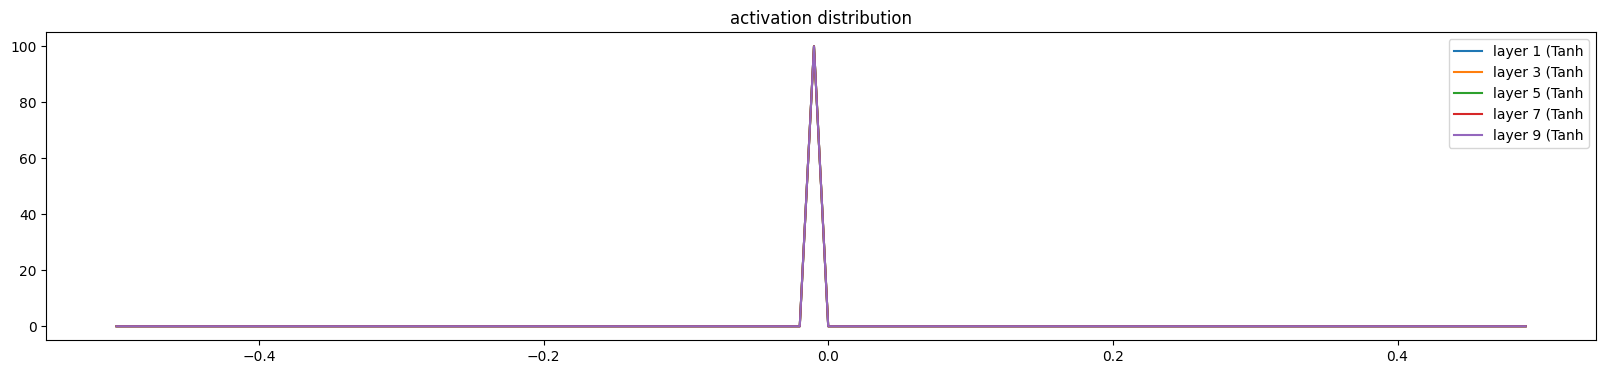

In [9]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

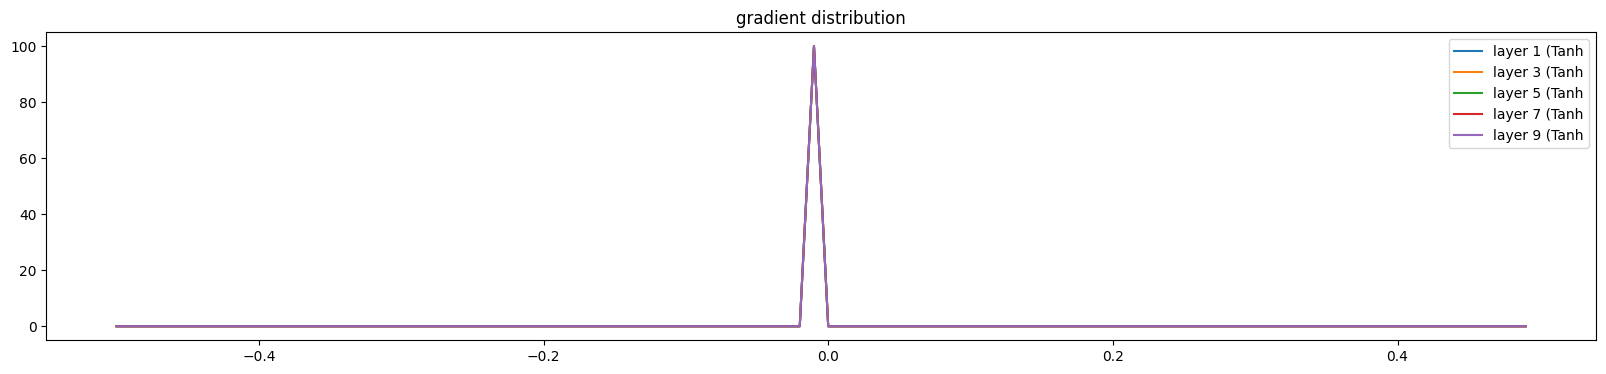

In [10]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight shape (27, 10) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (30, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 27) | mean 0.00000 | std 0.00000 | grad:data ratio nan
last layer weight shape (27,) | mean 0.00000 | std 0.04826 | grad:data ratio 3.95e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

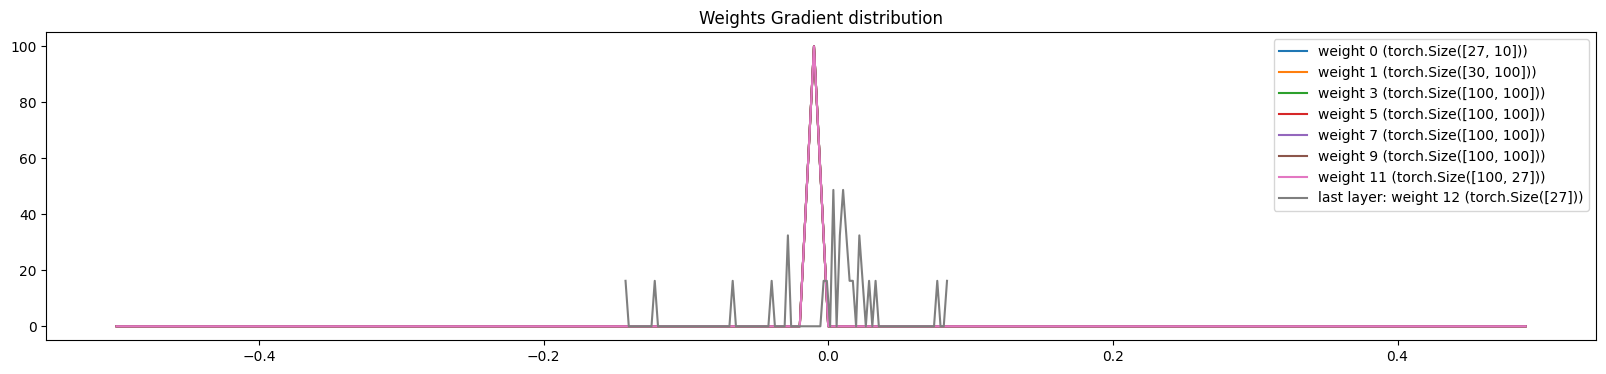

In [11]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  t = p.grad

  # neglect bias and batch norm parameters (weights only)
  if p.ndim == 2:
      print(f"weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())

      legends.append(f"weight {i} ({p.shape})")

  if i == len(parameters) - 1:
      print(f"last layer weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())

      legends.append(f"last layer: weight {i} ({p.shape})")

plt.legend(legends)
plt.title("Weights Gradient distribution")



All the layers have 0 weights and biases, besides the last layer, which still has weights to 0 but its biases have somehow learned.

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

BatchNorm summary:

BatchNorm normalizes the inputs of each layer so that they have mean 0 and standard deviation of 1 (within a mini batch of data during training), in a 2 step process:

- Normalizing the batch by substracting its mean and dividing it by its standard deviation
- Scaling and shifting it by two learnable parameters called gamma and beta

At inference time, it is not necessary and can be removed from the network, this can be achieved by 'folding' it into the preceding linear layer (combining the weights and biases of the linear layer with the gamma and beta of the BatchNorm layer). Check the maths after it in [BatchNormalizationFolding](https://medium.com/data-science/speed-up-inference-with-batch-normalization-folding-8a45a83a89d8).

In [16]:
gain = 3/5 # Tanh, check torch.nn.init documentation
last_layer_confidence = 0.1

using_batch_norm = True
div_by_fan_in = True

In [17]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)
    if div_by_fan_in:
      self.weight = self.weight / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [18]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [19]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [20]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Token embedding matrix
#C = torch.randn((vocab_size, n_embd),            generator=g)
if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
        Linear(         n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) # you can add it here too
    ]

with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence

    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

16424


In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []


for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  lossi.append(loss.log10().item())

  with torch.no_grad():
    update_to_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2958
  10000/ 200000: 2.2706
  20000/ 200000: 1.8179
  30000/ 200000: 2.2288
  40000/ 200000: 2.3455
  50000/ 200000: 2.2993
  60000/ 200000: 2.0547
  70000/ 200000: 2.0707
  80000/ 200000: 2.3780
  90000/ 200000: 2.3806
 100000/ 200000: 2.3082
 110000/ 200000: 2.3191
 120000/ 200000: 2.3484
 130000/ 200000: 2.1239
 140000/ 200000: 2.1816
 150000/ 200000: 2.4362
 160000/ 200000: 2.1054
 170000/ 200000: 2.7874
 180000/ 200000: 2.5118
 190000/ 200000: 2.0426


Evaluate loss with BatchNorm

In [23]:
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev,Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 2.158442974090576
val 2.174389123916626
test 2.1771230697631836


Evaluate loss with folded BatchNorm to previous Linear Layer

In [24]:
def split_folded_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev,Ydev),
    'test': (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

  for layer in layers:
    if isinstance(layers[layer], Linear): # If linear the one right after is BatchNorm
      # l = Linear()
      l = Linear(layers[layer].weight.shape[0], layers[layer].weight.shape[1], bias = True)
      # l.weight = W * (gamma / sqrt(var + eps))
      l.weight = layers[layer].weight * (layers[layer + 1].gamma / torch.sqrt(layers[layer + 1].running_var + layers[layer + 1].eps))

      if layers[layer].bias is not None:
        # l.bias = (b - mean) * (gamma / sqrt(var + eps)) + beta
        l.bias = (layers[layer].bias - layers[layer + 1].running_mean) * (layers[layer + 1].gamma / torch.sqrt(layers[layer + 1].running_var + layers[layer + 1].eps)) + layers[layer + 1].beta

      x = l(x)

    if isinstance(layers[layer], Tanh):
      x = layers[layer](x)

  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 2.158442974090576
val 2.174389123916626
test 2.1771230697631836


As we can see we obtain the same forward pass once the BatchNormalization layers have been folded into the Linear Layers.